In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os

# import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.formula.api as smf

# Cleaning Dataset (todo in P3 main file)

In [5]:
actors = pd.read_pickle("./data/actors.pkl")
movies = pd.read_pickle("./data/movies.pkl").set_index('IMDb_ID')

actors_movies = actors.droplevel(0, axis=1).merge(movies['averageRating'],left_on='IMDb_ID', right_index=True)
actors_movies = actors_movies.drop(columns=['birthYear', 'movie_count_genre'])
actors_movies = actors_movies.replace("\\N", pd.NA)

In [6]:
# Input:
#   - year (int)
#   - range (int)
# Output:
#   - Range (str)
def create_range(year, range=10):
    start_range = (year // range) * range
    return "{} - {}".format(start_range, start_range + range)


actors_movies = actors_movies.sort_values(by='Movie release date')
actors_movies['ReleaseYearRange'] = actors_movies['Movie release date'].apply(lambda x: create_range(x))

In [12]:
# Calculate the 30th and 70th percentiles
low_threshold = actors_movies['averageRating'].quantile(0.3)
high_threshold = actors_movies['averageRating'].quantile(0.7)

# Filter the DataFrame to keep only the rows in the lowest 30% and highest 30%
actors_movies = actors_movies[(actors_movies['averageRating'] <= low_threshold) | (actors_movies['averageRating'] >= high_threshold)]

In [15]:
display(actors_movies)

ordering  Wikipedia movie ID  \
IMDb_ID   IMDb_actor_ID                                 
tt0021287 nm0001196             1            26943847   
          nm0199841             2            26943847   
          nm0002143             3            26943847   
tt0021132 nm0269567             1            10365631   
          nm0850896             3            10365631   
...                           ...                 ...   
tt2164862 nm6793723             3            35841155   
tt1634286 nm0024404             3            29840120   
tt2077851 nm1898126             1            23394871   
tt1586265 nm0000139             1            32504587   
tt2064849 nm2390814             2            33567266   

                                                   Movie name  \
IMDb_ID   IMDb_actor_ID                                         
tt0021287 nm0001196                     Reaching for the Moon   
          nm0199841                     Reaching for the Moon   
          nm0002143                     Reaching for the Moon   
tt0021132 nm0269567                       The Matrimonial Bed   
          nm0850896                       The Matrimonial Bed   
...                                                       ...   
tt2164862 nm6793723                            Wagner's Dream   
tt1634286 nm0024404                                Grassroots   
tt2077851 nm1898126                         Sleepwalk with Me   
tt1586265 nm0000139      What to Expect When You're Expecting   
tt2064849 nm2390814                     London Paris New York   

                         Movie release date            primaryName  awards  \
IMDb_ID   IMDb_actor_ID                                                      
tt0021287 nm0001196                    1930      Douglas Fairbanks       0   
          nm0199841                    1930           Bebe Daniels       0   
          nm0002143                    1930  Edward Everett Horton       0   
tt0021132 nm0269567                    1930              Frank Fay       0   
          nm0850896                    1930         Lilyan Tashman       0   
...                                     ...                    ...     ...   
tt2164862 nm6793723                    2012        Jessica Krueger       0   
tt1634286 nm0024404                    2012         Lauren Ambrose       0   
tt2077851 nm1898126                    2012         Mike Birbiglia       0   
tt1586265 nm0000139                    2012           Cameron Diaz       0   
tt2064849 nm2390814                    2012       Aditi Rao Hydari       0   

                         nominations  movie_count  genres_b4  isMale  \
IMDb_ID   IMDb_actor_ID                                                
tt0021287 nm0001196                0            1          1       1   
          nm0199841                0            2          9       0   
          nm0002143                0            1          1       1   
tt0021132 nm0269567                0            3          9       1   
          nm0850896                0            1          1       0   
...                              ...          ...        ...     ...   
tt2164862 nm6793723                0            1          1    <NA>   
tt1634286 nm0024404                0            5          9       0   
tt2077851 nm1898126                0            1          1       1   
tt1586265 nm0000139                0           28         43       0   
tt2064849 nm2390814                0            1          1       0   

                         age_at_release  averageRating ReleaseYearRange  
IMDb_ID   IMDb_actor_ID                                                  
tt0021287 nm0001196                  47            5.5      1930 - 1940  
          nm0199841                  29            5.5      1930 - 1940  
          nm0002143                  44            5.5      1930 - 1940  
tt0021132 nm0269567                  39            5.7      1930 - 1940  
          nm0850896                  34  

# First analysis using t-test

In [23]:
# - ttest pour chaque feature sur toutes années confondues (6 ttest) (Armance)
#     - voire influence generale

# Text résumant les résultats

# Visualizing the evolution of features over time

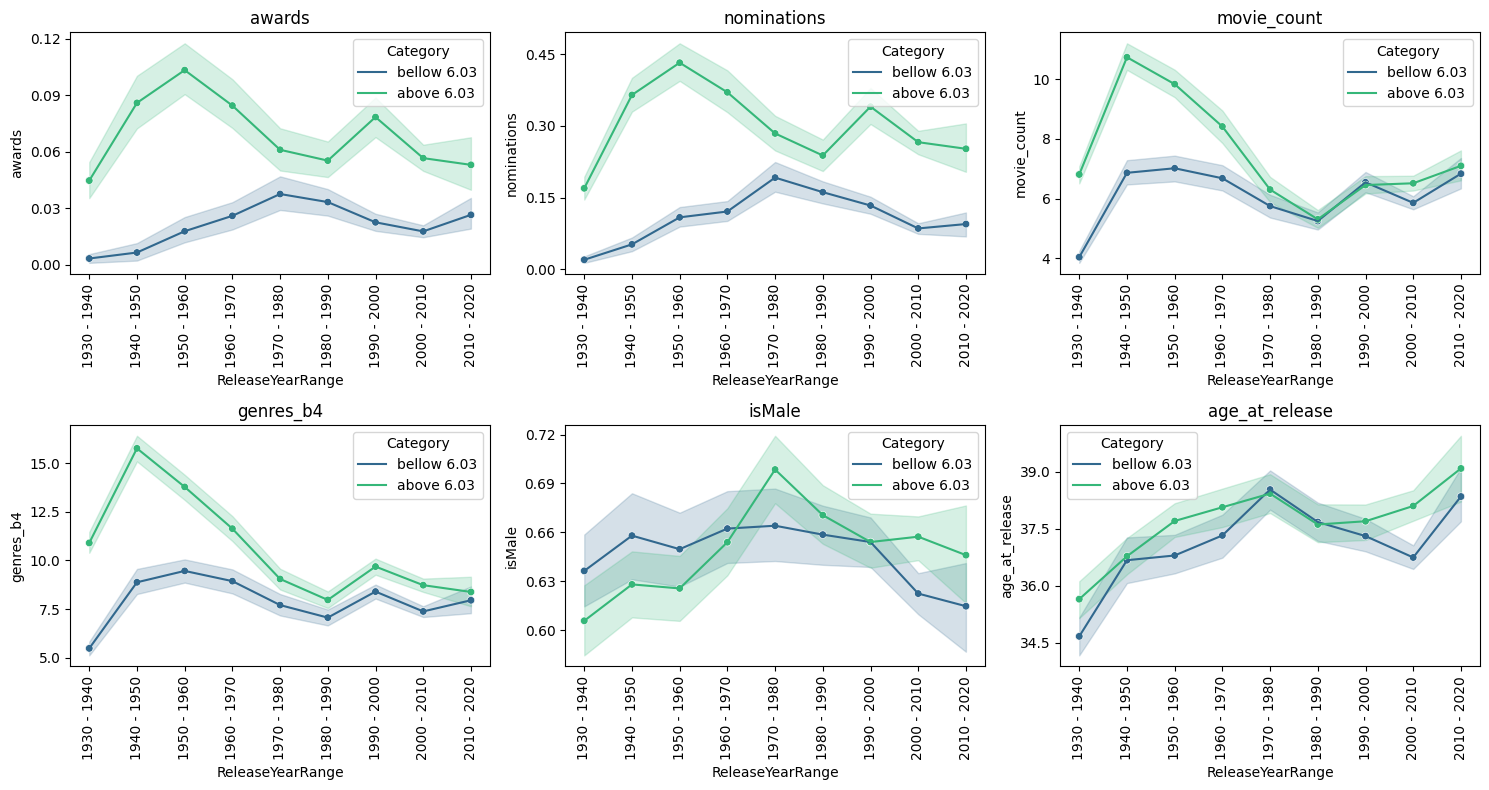

In [22]:
def do_fancy_ecpi_cute_plot(df, cat, diff, x, y_list, titles, ncols=3, max_y_ticks=5):

    nrows = -(-len(y_list) // ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

    lo = df.query(f'{diff} < @{cat}').copy()
    hi = df.query(f'{diff} >= @{cat}').copy()
    # me = df.copy()
    
    lo.loc[:, 'Category'] = 'bellow {}'.format(globals()[cat])
    hi.loc[:, 'Category'] = 'above {}'.format(globals()[cat])
    # me.loc[:, 'Category'] = 'mean'

    for i, (y, title) in enumerate(zip(y_list, titles)):

        lo_filtered = lo[lo[y].notna()]
        hi_filtered = hi[hi[y].notna()]
        # me_filtered = me[me[y].notna()]

        lo_filtered.loc[:, y] = pd.to_numeric(lo_filtered[y])
        hi_filtered.loc[:, y] = pd.to_numeric(hi_filtered[y])
        # me_filtered.loc[:, y] = pd.to_numeric(me_filtered[y])
        
        lo_filtered_mean = lo_filtered.groupby(x)[y].mean().reset_index()
        lo_filtered_mean['Category'] = 'bellow {}'.format(globals()[cat])

        hi_filtered_mean = hi_filtered.groupby(x)[y].mean().reset_index()
        hi_filtered_mean['Category'] = 'above {}'.format(globals()[cat])

        # me_filtered_mean = me_filtered.groupby(x)[y].mean().reset_index()
        # me_filtered_mean['Category'] = 'mean'

        # frame = pd.concat([lo_filtered, hi_filtered, me_filtered])
        frame = pd.concat([lo_filtered, hi_filtered])

        # frame_mean = pd.concat([lo_filtered_mean, hi_filtered_mean, me_filtered_mean])
        frame_mean = pd.concat([lo_filtered_mean, hi_filtered_mean])
    
        ax = axes[i // ncols, i % ncols]
        sns.lineplot(data=frame, x=x, y=y, hue='Category', errorbar='ci', palette='viridis', ax=ax)
        sns.scatterplot(data=frame_mean, x=x, y=y, hue='Category', palette='viridis', ax=ax, legend=False, marker='o', s=30)
        ax.set_title(title)
        ax.legend(title='Category')

        # Rotate x-axis labels
        for label in ax.get_xticklabels():
            label.set_rotation(90)

        # Set y-axis tick frequency
        ax.yaxis.set_major_locator(MaxNLocator(nbins=max_y_ticks))
    

    # Turn off any unused subplots
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')

    plt.tight_layout()
    plt.show()

mean_rating = round(actors_movies['averageRating'].mean(), 2)
do_fancy_ecpi_cute_plot(actors_movies, 'mean_rating', 'averageRating', 'ReleaseYearRange', 
                        ['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release'], 
                        ['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release'])

- Awards: Actors in movies rated above 6.03 tend to have accumulated more awards across the years compared to those in movies with ratings below 6.03.

- Nominations: Similarly, actors in higher-rated movies have received more nominations over the years.

- Movie Count: Actors in higher-rated movies have appeared in a greater number of movies, especially in the time frame from the 1940s to the early 2000s.

- Genres Before Current Movie (genres_b4): Actors in higher-rated movies have tended to play in a greater variety of genres before their current movie, with the difference being most pronounced in the early release years.

- IsMale (Gender Distribution): The proportion of male actors varies with time, and there's a higher proportion of male actors in movies above the 6.03 rating threshold in certain time periods. However, the overlapping confidence intervals suggest a significant variance in the data.

- Age at Release: Actors in higher-rated movies are generally older, particularly noticeable from the 1980s onward, whereas in earlier decades, the trend is not as distinct.

The plots suggest there are observable differences in the features of actors between high and low-rated movies. Specifically, actors in higher-rated movies have a history of more awards and nominations, have appeared in more movies, have had experience across a wider range of genres before the current movie, and are typically older at the time of the movie's release. The gender distribution is somewhat variable and does not show as clear a trend. These findings indicate that actors' experience and recognition (in terms of awards and variety of roles) may correlate with the ratings of the movies they are in.

# Awards X Average Ratings

In [25]:
# Viz pointplot check awards X average Ratings (Kelan)

# Feature Correlation

In [27]:
# - Correlation Emeline (Emeline)
#     - Correspond avec graph dimi mais en term de correlation

# Correlation Features with Ratings

In [ ]:
# - Correlation avec ratings (Kelan)
#     - Awards et nominations ont le plus gros impact mais ils sont corellés entre eux

# Analysis with Matching

In [ ]:
# - Linear model (peut etre logistic regression) (Theo)
#     - voir si awards a vraiment une influence ou pas, check p value
# - Matching (Theo)
#     - avec awards, check if awards really has an influence on ratings
# - Linear model (peut etre logistic regression) (Theo)
#     - voir si awards a vraiment une influence ou pas, check pvalue, et la difference ave 1ere logreg

# PCA

In [ ]:
# - PCA (Emeline)
#     - lookout for clusters

# Conclusion and future work